In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [2]:
def get_adj(station, var):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    if var == 'RAOBCORE_bias_estimate':
        file = ('./Temperature_adjustment/0'+station+'/feedbackglobbincorrsave0'+station+'.nc')
    elif var == 'RISE_bias_estimate':
        file = glob.glob('./Temperature_adjustment/0'+station+'/*corrsave*rio24*'+station+'.nc')[0]
    data = eua.CDMDataset(file)
    
    breakdates = []
    for i in data.datum[:][0]:
        breakdates.append(date0 + datetime.timedelta(days=int(i)))

    press = data.press[:]
    nightadj = data.rasocorr[0,:]
    dayadj = data.rasocorr[1,:]

    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'temperature',
                    'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    print(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    
#     breakdates.append(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    dates = breakdates
#     dates.reverse()
    print(dates)
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daydata[daydata.plev == press[j]*100][daydata.time >= dates[i]][daydata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd[var].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightdata[nightdata.plev == press[j]*100][nightdata.time >= dates[i]][nightdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd[var].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, cds_day_out, cds_night_out, calc_day_out, calc_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, adj, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    ax.scatter(dates[1:], cdata[str(plev)], label='CDS')
    ax.scatter(dates[1:], adata[str(plev)], label='Calc')

    ax.set(xlabel='breaks', ylabel='Adjustment: '+adj,
           title= str(station)+' Temperature '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

In [4]:
def get_sacadj(station, var):
    import datetime
    """Compare created solarangle corrected adjustment to downloaded adjustment
    """
    if var == 'RASE_bias_estimate':
        tarvar = 'bias'
    elif var == 'RICH_bias_estimate':
        tarvar = 'richbias'
    file = glob.glob('./Temperature_adjustment/0'+station+'/*ERA5bc*'+station+'.nc')[0]
    data = eua.CDMDataset(file)
    
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")
#     dates = []
#     for i in data.datum[:]:
#         dates.append(date0 + datetime.timedelta(days=int(i)))
    
    lessdates = []
    basedatum = data.datum[:]
    for i in range(basedatum[0], basedatum[-1], 1000):
        lessdates.append(date0 + datetime.timedelta(days=int(i)))
    dates = lessdates
    
    press = data.press[:]
    print(press)
    nightadj = data[tarvar][0,:]
    dayadj = data[tarvar][1,:]

    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'temperature',
                    'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    print(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
        
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i*300]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daydata[daydata.plev == press[j]*100][daydata.time >= dates[i]][daydata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd[var].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightdata[nightdata.plev == press[j]*100][nightdata.time >= dates[i]][nightdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd[var].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i*300]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, cds_day_out, cds_night_out, calc_day_out, calc_night_out

In [5]:
# def get_sacadj(station, var):
#     import datetime
#     """Compare created solarangle corrected adjustment to downloaded adjustment
#     """
#     if var == 'RASE_bias_estimate':
#         tarvar = 'bias'
#     elif var == 'RICH_bias_estimate':
#         tarvar = 'richbias'
#     file = glob.glob('./Temperature_adjustment/0'+station+'/*ERA5bc*'+station+'.nc')[0]
#     data = eua.CDMDataset(file)
    
#     date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")
#     dates = []
#     for i in data.datum[:]:
#         dates.append(date0 + datetime.timedelta(days=int(i)))
    
#     press = data.press[:]
#     nightadj = data[tarvar][0,:]
#     dayadj = data[tarvar][1,:]

#     c = cdsapi.Client()
#     r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
#                    {'variable': 'temperature',
#                     'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
#                     'statid': station,
#                     'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
#                    }
#                   )
#     r.download(target='download.zip')
#     assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
#     z = zipfile.ZipFile('download.zip')
#     z.extractall(path='./tocompare/cds_'+station)
#     z.close()
#     cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
#     cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
#     daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
#     day_cdsdates = daydata.time
#     nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
#     night_cdsdates = nightdata.time
    
#     calc_day_out = {}
#     calc_night_out = {}
#     cds_day_out = {}
#     cds_night_out = {}
#     print('dates', len(dates))
#     for j in range(len(press)):
#         calc_day_out[str(int(press[j]))] = dayadj[j][:]
#         cds_day_out[str(int(press[j]))] = daydata[daydata.plev == press[j]*100]
#         cds_night_out[str(int(press[j]))] = nightdata[nightdata.plev == press[j]*100]
#         calc_night_out[str(int(press[j]))] = nightadj[j][:]
#         if press[j] in [100, 500, 850]:
#             plt_sacadj(dates, nightdata[nightdata.plev == press[j]*100].time, nightdata[nightdata.plev == press[j]*100][var], nightadj[j][:], press[j], station, 'night', var, save=False)
#             plt_sacadj(dates, daydata[daydata.plev == press[j]*100].time, daydata[daydata.plev == press[j]*100][var], dayadj[j][:], press[j], station, 'day', var, save=False)

#     return dates, day_cdsdates, night_cdsdates, calc_day_out, calc_night_out, cds_day_out, cds_night_out

In [6]:
# def plt_sacadj(dates, cdsdates, cdata, adata, plev, station, time, adj, save):
# #     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
#     fig, ax = plt.subplots()
#     ax.scatter(cdsdates, cdata, label='CDS')
#     ax.scatter(dates, adata, label='Calc')

#     ax.set(xlabel='breaks', ylabel='Adjustment: '+adj,
#            title= str(station)+' Temperature '+str(plev)+' hPa '+time)
#     ax.legend()
#     ax.grid()
    
#     if save:
#         fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
#     plt.show()
#     return

In [7]:
# station = '70219'
# adj = 'RICH_bias_estimate'
# dates,cdsdd, cdsnd, cd, cn, ad, an = get_sacadj(station, adj)

2021-06-10 15:23:03,739 INFO Welcome to the CDS
2021-06-10 15:23:03,741 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:23:04,140 INFO Request is queued
2021-06-10 15:23:05,179 INFO Request is running
2021-06-10 15:23:12,417 INFO Request is completed
2021-06-10 15:23:12,419 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331389.6575015-31659-15-2cbaadc2-7099-4afc-b28e-d4dae5c4d0cd.zip to download.zip (28.1M)
2021-06-10 15:23:14,462 INFO Download rate 13.8M/s  
2021-06-10 15:23:14,818 INFO Reading Profile on slice(None, None, None)
2021-06-10 15:23:20,218 INFO Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-10 15:23:20,220 INFO NumExpr defaulting to 8 threads.


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 13, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1955, 7, 21, 0, 0), datetime.datetime(1956, 8, 5, 0, 0), datetime.datetime(1958, 8, 13, 0, 0), datetime.datetime(1960, 11, 12, 0, 0), datetime.datetime(1963, 9, 7, 0, 0), datetime.datetime(1964, 12, 21, 0, 0), datetime.datetime(1970, 9, 7, 0, 0), datetime.datetime(1975, 8, 7, 0, 0), datetime.datetime(1977, 12, 4, 0, 0), datetime.datetime(1980, 9, 14, 0, 0), datetime.datetime(1982, 11, 21, 0, 0), datetime.datetime(1984, 1, 27, 0, 0), datetime.datetime(1989, 7, 1, 0, 0), datetime.datetime(1992, 2, 28, 0, 0), datetime.datetime(1995, 6, 12, 0, 0), datetime.datetime(1997, 7, 12, 0, 0), datetime.datetime(1999, 9, 5, 0, 0), datetime.datetime(2009, 3, 21, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


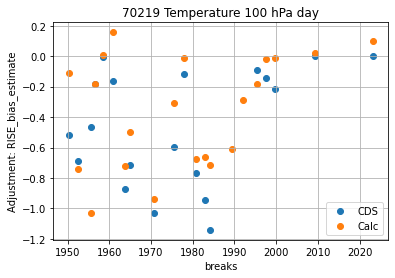

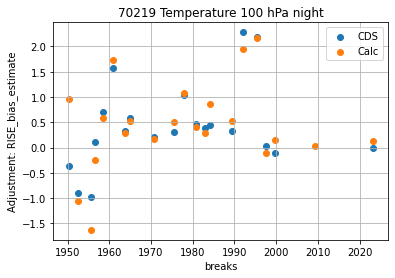

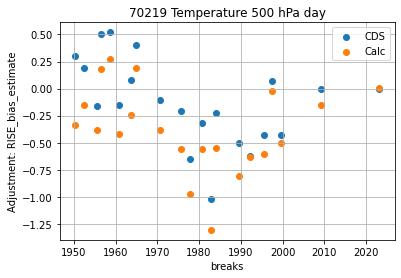

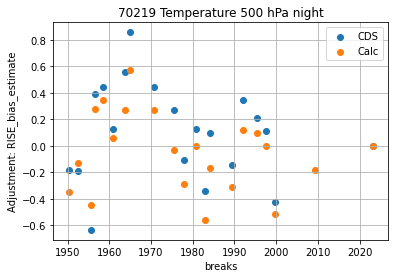

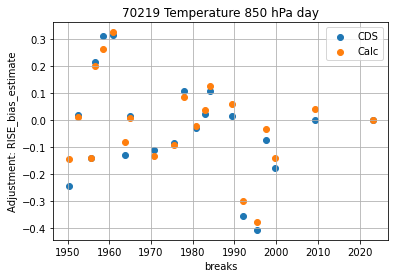

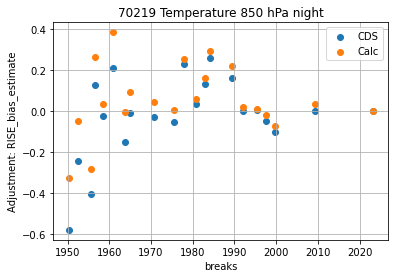

In [8]:
station = '70219'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)

plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:23:54,463 INFO Welcome to the CDS
2021-06-10 15:23:54,464 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:23:54,662 INFO Request is completed
2021-06-10 15:23:54,665 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331389.6575015-31659-15-2cbaadc2-7099-4afc-b28e-d4dae5c4d0cd.zip to download.zip (28.1M)
2021-06-10 15:23:56,845 INFO Download rate 12.9M/s  
2021-06-10 15:23:57,329 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00


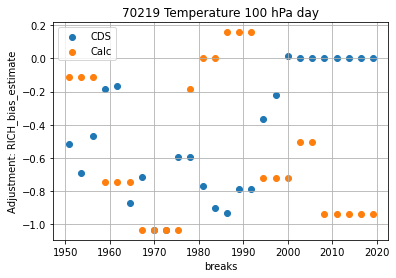

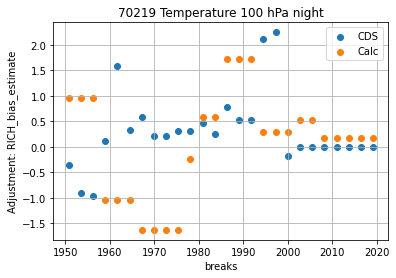

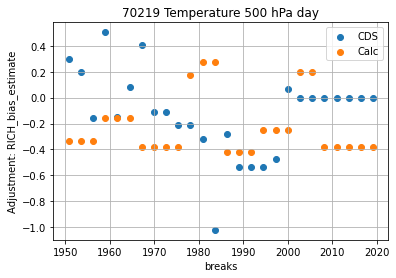

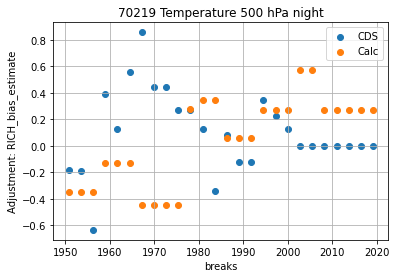

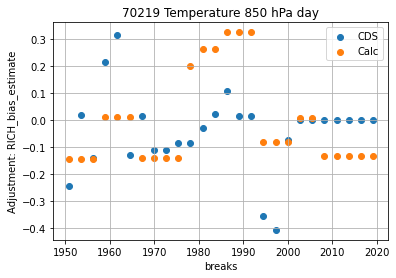

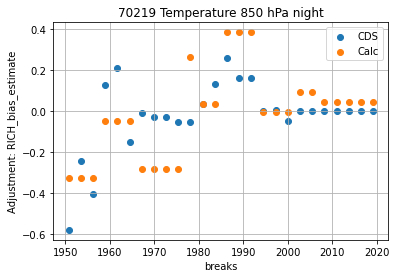

In [9]:
station = '70219'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)

plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:24:27,382 INFO Welcome to the CDS
2021-06-10 15:24:27,384 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:24:27,681 INFO Request is completed
2021-06-10 15:24:27,683 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331389.6575015-31659-15-2cbaadc2-7099-4afc-b28e-d4dae5c4d0cd.zip to download.zip (28.1M)
2021-06-10 15:24:29,851 INFO Download rate 13M/s    
2021-06-10 15:24:30,311 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 12, 0, 0), datetime.datetime(1952, 6, 17, 0, 0), datetime.datetime(1955, 7, 20, 0, 0), datetime.datetime(1956, 8, 4, 0, 0), datetime.datetime(1958, 8, 12, 0, 0), datetime.datetime(1960, 11, 11, 0, 0), datetime.datetime(1963, 9, 6, 0, 0), datetime.datetime(1964, 12, 20, 0, 0), datetime.datetime(1970, 9, 6, 0, 0), datetime.datetime(1975, 8, 6, 0, 0), datetime.datetime(1977, 12, 3, 0, 0), datetime.datetime(1980, 9, 13, 0, 0), datetime.datetime(1982, 11, 20, 0, 0), datetime.datetime(1984, 1, 26, 0, 0), datetime.datetime(1989, 6, 30, 0, 0), datetime.datetime(1992, 2, 27, 0, 0), datetime.datetime(1995, 6, 11, 0, 0), datetime.datetime(1997, 7, 11, 0, 0), datetime.datetime(1999, 9, 4, 0, 0), datetime.datetime(2009, 3, 20, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


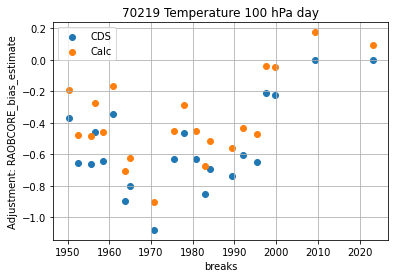

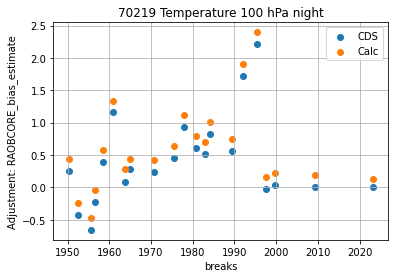

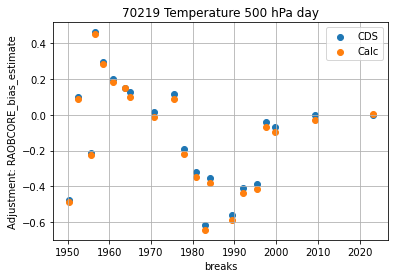

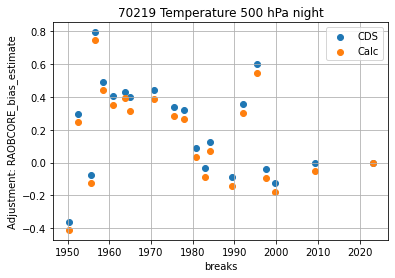

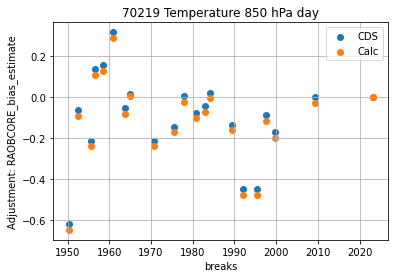

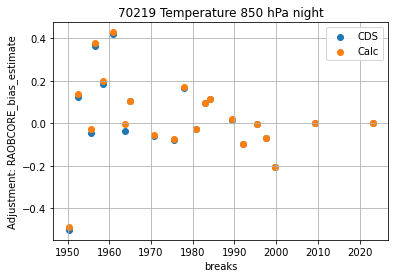

In [10]:
station = '70219'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:24:47,042 INFO Welcome to the CDS
2021-06-10 15:24:47,043 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:24:47,201 INFO Request is completed
2021-06-10 15:24:47,203 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331389.6575015-31659-15-2cbaadc2-7099-4afc-b28e-d4dae5c4d0cd.zip to download.zip (28.1M)
2021-06-10 15:24:49,434 INFO Download rate 12.6M/s  
2021-06-10 15:24:49,648 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00


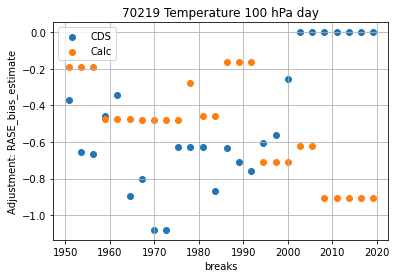

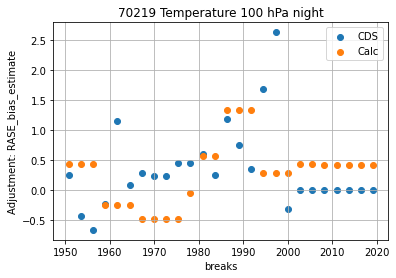

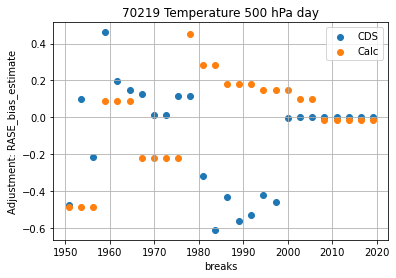

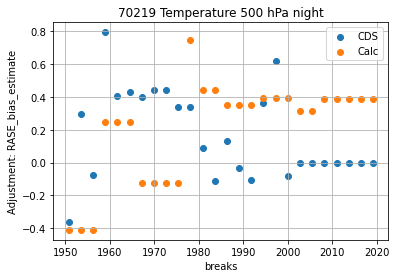

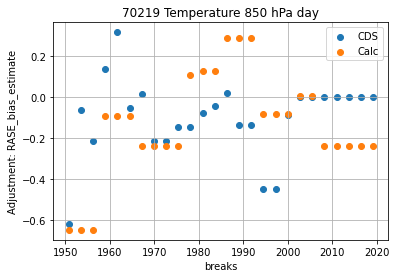

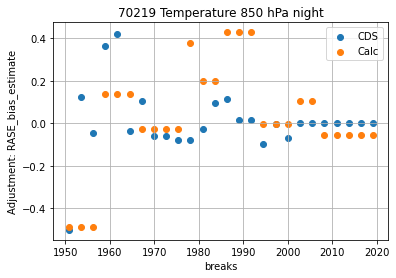

In [11]:
station = '70219'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:25:06,381 INFO Welcome to the CDS
2021-06-10 15:25:06,382 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:25:06,537 INFO Request is queued
2021-06-10 15:25:07,575 INFO Request is running
2021-06-10 15:25:09,114 INFO Request is completed
2021-06-10 15:25:09,115 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331508.7265399-9384-12-47b87e56-3403-4d9e-8273-5a629ffc9a92.zip to download.zip (30.7M)
2021-06-10 15:25:11,676 INFO Download rate 12M/s    
2021-06-10 15:25:12,109 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1956, 4, 28, 0, 0), datetime.datetime(1958, 5, 19, 0, 0), datetime.datetime(1959, 4, 1, 0, 0), datetime.datetime(1960, 5, 27, 0, 0), datetime.datetime(1965, 7, 12, 0, 0), datetime.datetime(1967, 11, 27, 0, 0), datetime.datetime(1972, 3, 13, 0, 0), datetime.datetime(1975, 1, 4, 0, 0), datetime.datetime(1978, 12, 31, 0, 0), datetime.datetime(1981, 1, 25, 0, 0), datetime.datetime(1981, 10, 14, 0, 0), datetime.datetime(1984, 5, 31, 0, 0), datetime.datetime(1988, 1, 26, 0, 0), datetime.datetime(1990, 6, 14, 0, 0), datetime.datetime(1995, 11, 22, 0, 0), datetime.datetime(2003, 4, 26, 0, 0), datetime.datetime(2011, 6, 1, 0, 0), datetime.datetime(2014, 11, 12, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


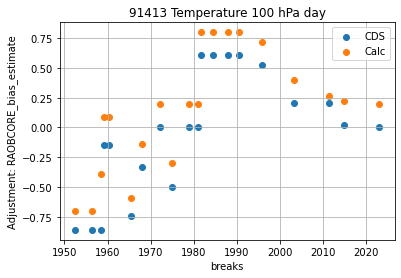

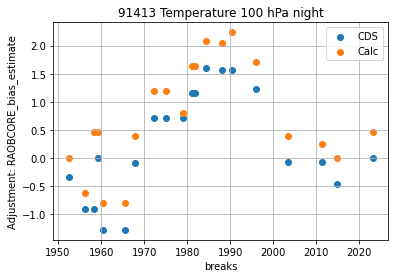

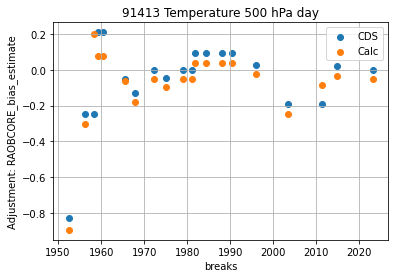

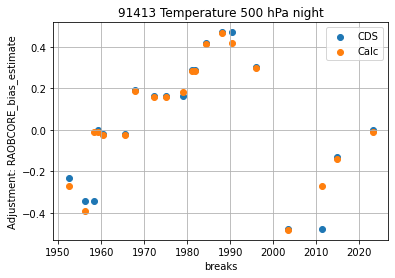

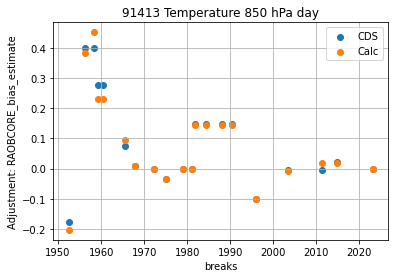

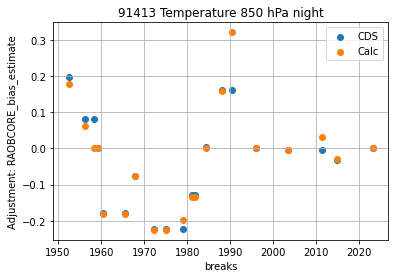

In [12]:
station = '91413'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:25:30,614 INFO Welcome to the CDS
2021-06-10 15:25:30,614 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:25:30,789 INFO Request is completed
2021-06-10 15:25:30,791 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331508.7265399-9384-12-47b87e56-3403-4d9e-8273-5a629ffc9a92.zip to download.zip (30.7M)
2021-06-10 15:25:33,554 INFO Download rate 11.1M/s  
2021-06-10 15:25:34,008 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00


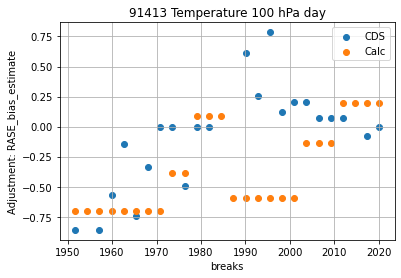

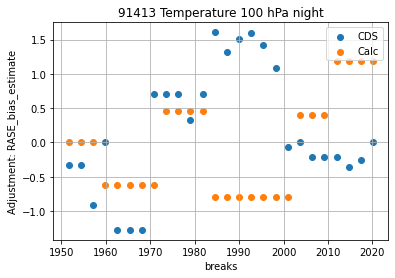

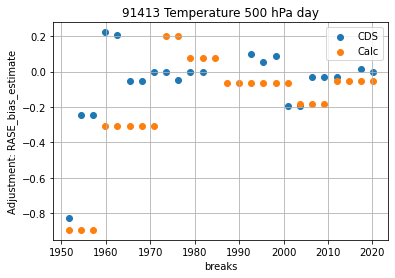

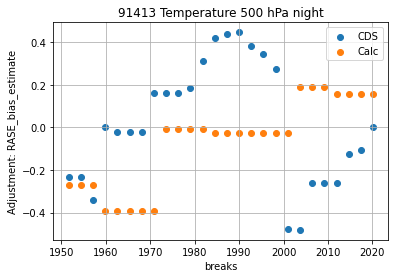

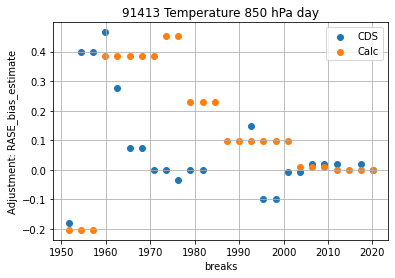

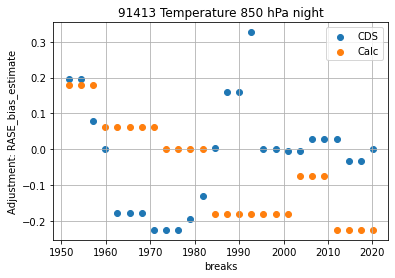

In [13]:
station = '91413'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:25:52,677 INFO Welcome to the CDS
2021-06-10 15:25:52,677 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:25:53,410 INFO Request is completed
2021-06-10 15:25:53,412 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331508.7265399-9384-12-47b87e56-3403-4d9e-8273-5a629ffc9a92.zip to download.zip (30.7M)
2021-06-10 15:25:56,149 INFO Download rate 11.2M/s  
2021-06-10 15:25:56,748 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 19, 0, 0), datetime.datetime(1956, 4, 29, 0, 0), datetime.datetime(1958, 5, 20, 0, 0), datetime.datetime(1960, 5, 28, 0, 0), datetime.datetime(1963, 3, 12, 0, 0), datetime.datetime(1972, 3, 14, 0, 0), datetime.datetime(1975, 1, 5, 0, 0), datetime.datetime(1979, 1, 1, 0, 0), datetime.datetime(1981, 1, 26, 0, 0), datetime.datetime(1981, 10, 15, 0, 0), datetime.datetime(1984, 6, 1, 0, 0), datetime.datetime(1988, 1, 27, 0, 0), datetime.datetime(1990, 6, 15, 0, 0), datetime.datetime(1995, 11, 23, 0, 0), datetime.datetime(2003, 4, 27, 0, 0), datetime.datetime(2011, 6, 2, 0, 0), datetime.datetime(2014, 11, 13, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


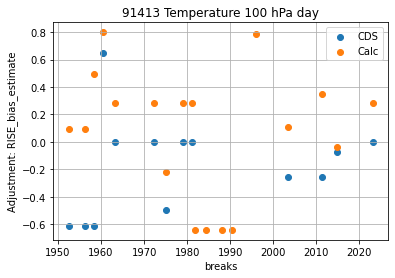

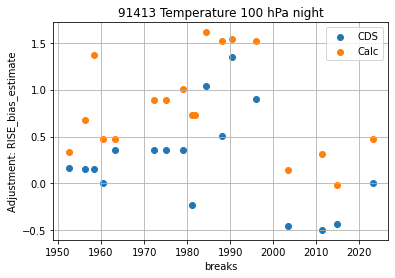

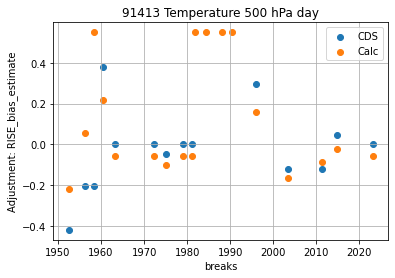

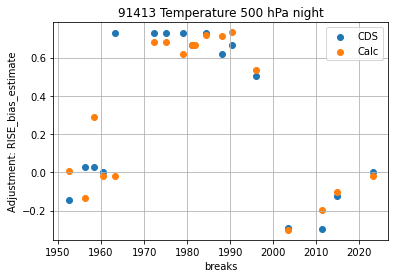

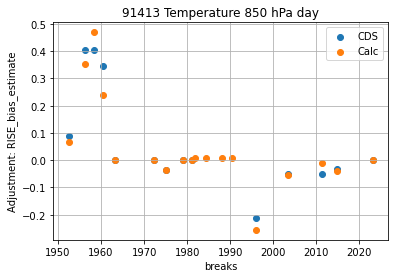

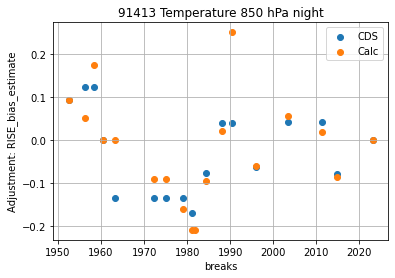

In [14]:
station = '91413'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:26:12,272 INFO Welcome to the CDS
2021-06-10 15:26:12,273 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:26:12,526 INFO Request is completed
2021-06-10 15:26:12,528 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331508.7265399-9384-12-47b87e56-3403-4d9e-8273-5a629ffc9a92.zip to download.zip (30.7M)
2021-06-10 15:26:15,818 INFO Download rate 9.3M/s   
2021-06-10 15:26:16,292 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00


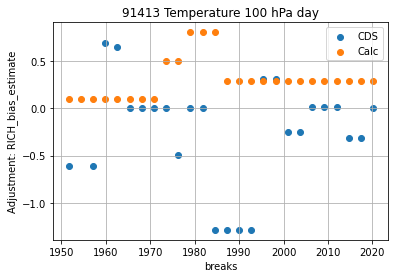

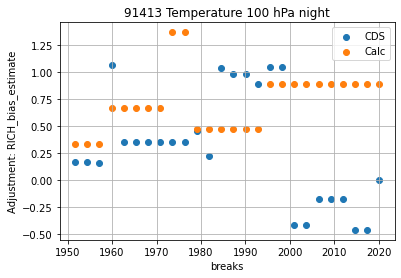

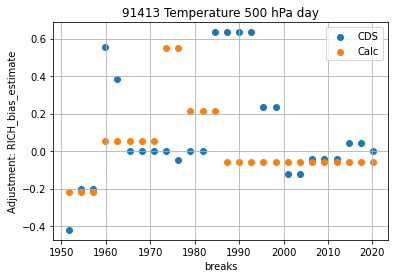

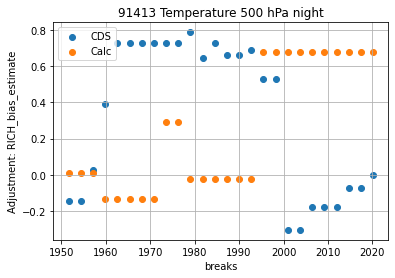

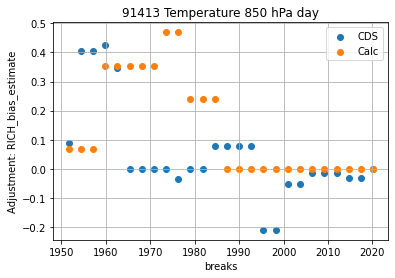

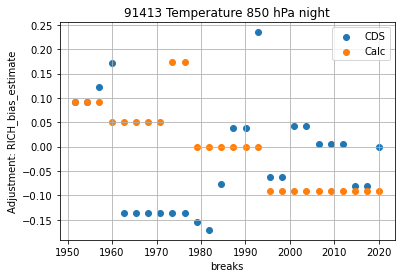

In [15]:
station = '91413'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:26:34,713 INFO Welcome to the CDS
2021-06-10 15:26:34,714 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:26:34,888 INFO Request is queued
2021-06-10 15:26:35,925 INFO Request is running
2021-06-10 15:27:07,335 INFO Request is completed
2021-06-10 15:27:07,337 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1623331615.7180169-9427-13-5316565b-84f3-4aa4-aac1-34ec37ff3546.zip to download.zip (43.3M)
2021-06-10 15:27:13,234 INFO Download rate 7.3M/s   
2021-06-10 15:27:13,822 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 2, 0, 0), datetime.datetime(1957, 1, 21, 0, 0), datetime.datetime(1960, 1, 16, 0, 0), datetime.datetime(1962, 2, 8, 0, 0), datetime.datetime(1963, 2, 11, 0, 0), datetime.datetime(1968, 1, 3, 0, 0), datetime.datetime(1970, 3, 3, 0, 0), datetime.datetime(1979, 11, 2, 0, 0), datetime.datetime(1984, 8, 6, 0, 0), datetime.datetime(1987, 1, 17, 0, 0), datetime.datetime(1989, 4, 2, 0, 0), datetime.datetime(1991, 2, 16, 0, 0), datetime.datetime(1992, 3, 24, 0, 0), datetime.datetime(1994, 10, 12, 0, 0), datetime.datetime(2004, 5, 12, 0, 0), datetime.datetime(2006, 7, 1, 0, 0), datetime.datetime(2010, 7, 10, 0, 0), datetime.datetime(2017, 2, 3, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


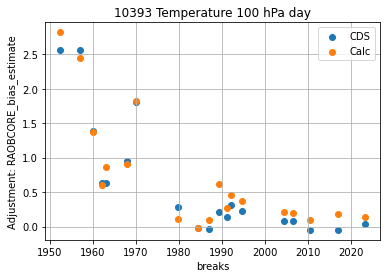

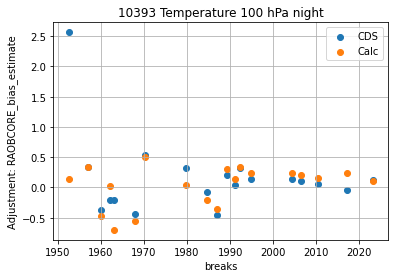

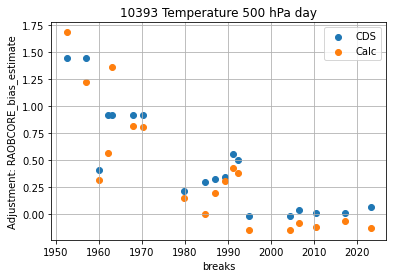

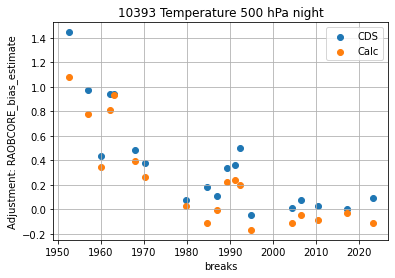

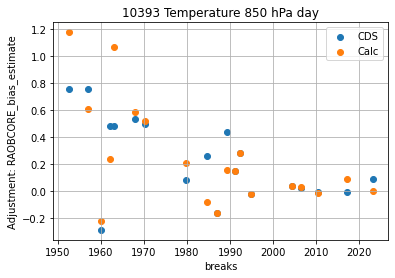

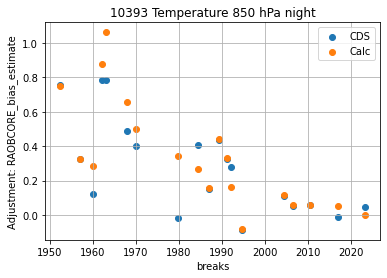

In [16]:
station = '10393'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:27:42,859 INFO Welcome to the CDS
2021-06-10 15:27:42,859 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:27:43,030 INFO Request is completed
2021-06-10 15:27:43,030 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1623331615.7180169-9427-13-5316565b-84f3-4aa4-aac1-34ec37ff3546.zip to download.zip (43.3M)
2021-06-10 15:27:48,943 INFO Download rate 7.3M/s   
2021-06-10 15:27:49,608 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00


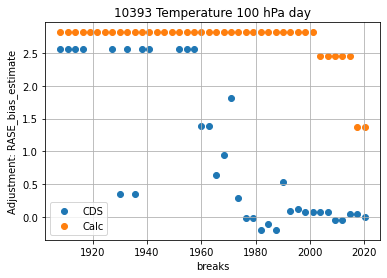

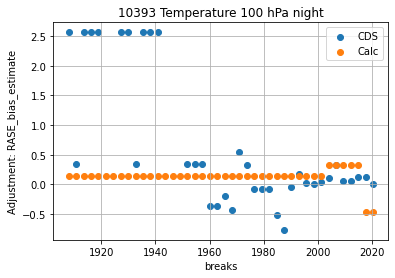

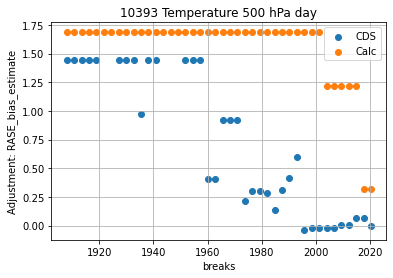

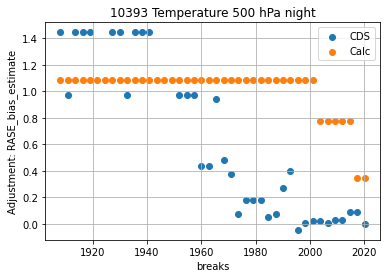

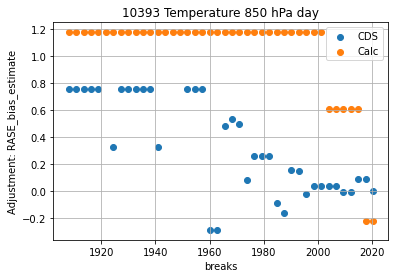

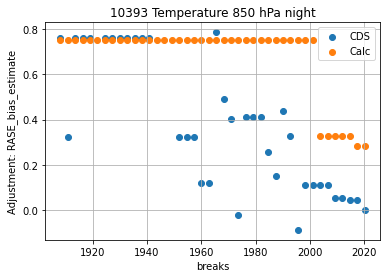

In [17]:
station = '10393'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:28:39,610 INFO Welcome to the CDS
2021-06-10 15:28:39,611 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:28:39,787 INFO Request is completed
2021-06-10 15:28:39,789 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1623331615.7180169-9427-13-5316565b-84f3-4aa4-aac1-34ec37ff3546.zip to download.zip (43.3M)
2021-06-10 15:28:46,474 INFO Download rate 6.5M/s   
2021-06-10 15:28:47,155 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 3, 0, 0), datetime.datetime(1957, 1, 22, 0, 0), datetime.datetime(1960, 1, 17, 0, 0), datetime.datetime(1962, 2, 9, 0, 0), datetime.datetime(1963, 2, 12, 0, 0), datetime.datetime(1968, 1, 4, 0, 0), datetime.datetime(1970, 3, 4, 0, 0), datetime.datetime(1979, 11, 3, 0, 0), datetime.datetime(1984, 8, 7, 0, 0), datetime.datetime(1987, 1, 18, 0, 0), datetime.datetime(1989, 4, 3, 0, 0), datetime.datetime(1991, 2, 17, 0, 0), datetime.datetime(1992, 3, 25, 0, 0), datetime.datetime(1994, 10, 13, 0, 0), datetime.datetime(2004, 5, 13, 0, 0), datetime.datetime(2006, 7, 2, 0, 0), datetime.datetime(2010, 7, 11, 0, 0), datetime.datetime(2017, 2, 4, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


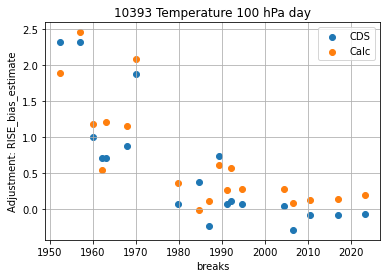

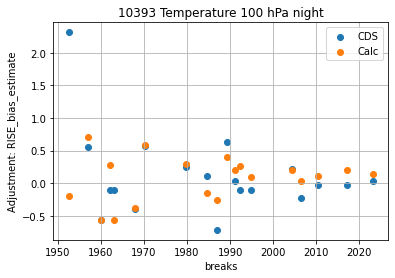

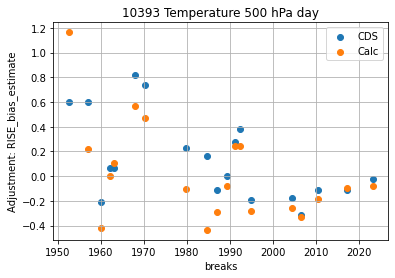

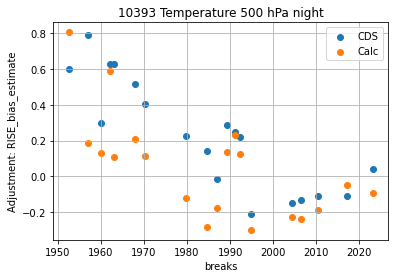

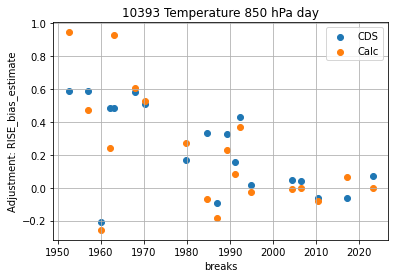

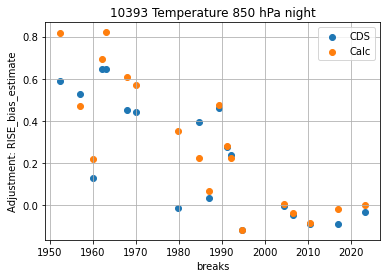

In [18]:
station = '10393'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:29:15,771 INFO Welcome to the CDS
2021-06-10 15:29:15,772 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:29:15,936 INFO Request is completed
2021-06-10 15:29:15,939 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1623331615.7180169-9427-13-5316565b-84f3-4aa4-aac1-34ec37ff3546.zip to download.zip (43.3M)
2021-06-10 15:29:21,031 INFO Download rate 8.5M/s   
2021-06-10 15:29:21,780 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00


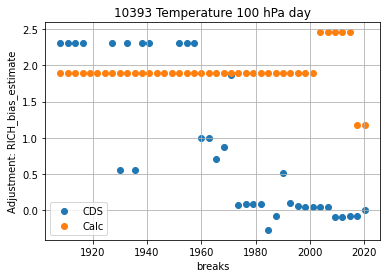

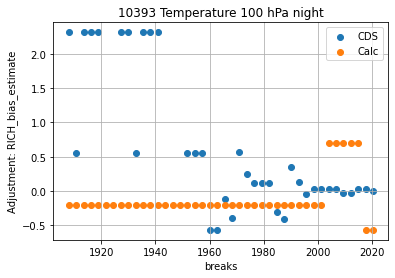

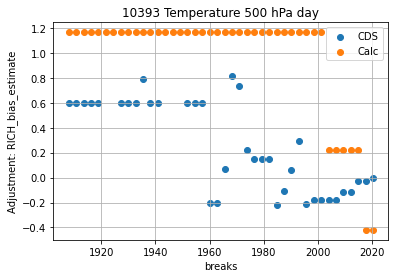

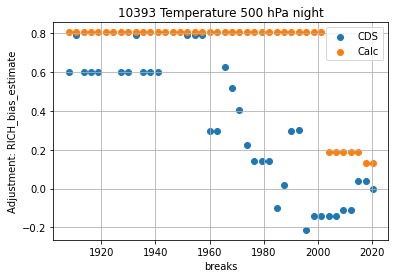

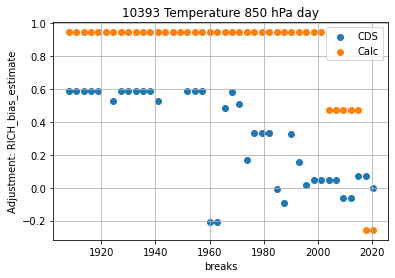

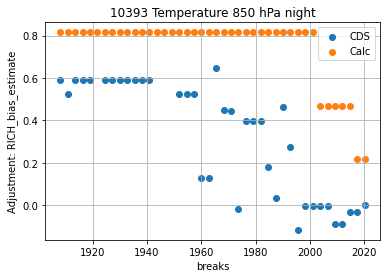

In [19]:
station = '10393'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:30:08,345 INFO Welcome to the CDS
2021-06-10 15:30:08,347 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:30:08,506 INFO Request is queued
2021-06-10 15:30:09,548 INFO Request is running
2021-06-10 15:30:13,376 INFO Request is completed
2021-06-10 15:30:13,378 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331812.4981277-29961-16-7a05dfd2-cc5e-4725-a362-a607cd389c1a.zip to download.zip (29M)
2021-06-10 15:30:17,608 INFO Download rate 6.9M/s   
2021-06-10 15:30:18,148 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1951, 9, 27, 0, 0), datetime.datetime(1956, 6, 22, 0, 0), datetime.datetime(1958, 6, 23, 0, 0), datetime.datetime(1963, 7, 11, 0, 0), datetime.datetime(1965, 8, 14, 0, 0), datetime.datetime(1968, 1, 1, 0, 0), datetime.datetime(1969, 10, 3, 0, 0), datetime.datetime(1973, 2, 14, 0, 0), datetime.datetime(1974, 11, 21, 0, 0), datetime.datetime(1976, 2, 3, 0, 0), datetime.datetime(1980, 3, 30, 0, 0), datetime.datetime(1982, 1, 18, 0, 0), datetime.datetime(1984, 1, 19, 0, 0), datetime.datetime(1987, 4, 15, 0, 0), datetime.datetime(1989, 8, 23, 0, 0), datetime.datetime(1994, 6, 4, 0, 0), datetime.datetime(1996, 8, 12, 0, 0), datetime.datetime(2016, 12, 14, 0, 0), datetime.datetime(2019, 5, 14, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


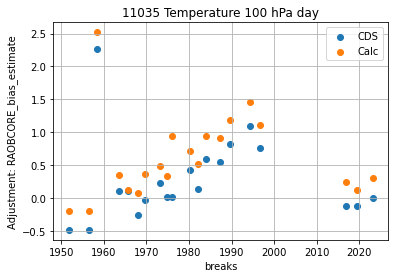

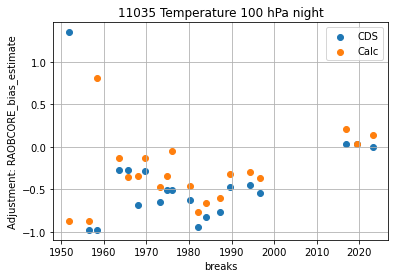

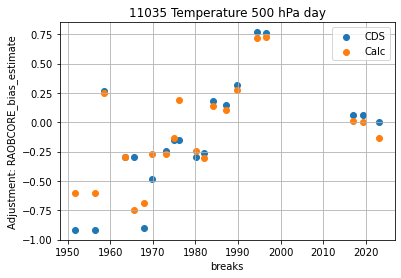

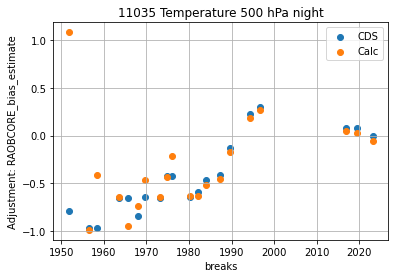

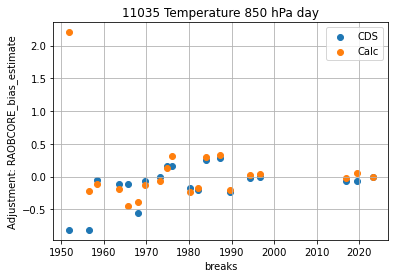

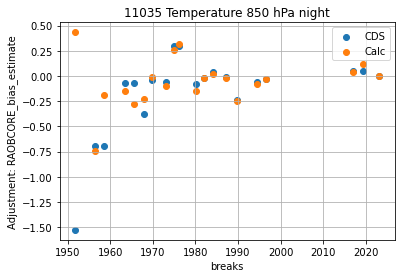

In [20]:
station = '11035'
adj = 'RAOBCORE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:30:38,047 INFO Welcome to the CDS
2021-06-10 15:30:38,048 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:30:38,217 INFO Request is completed
2021-06-10 15:30:38,218 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331812.4981277-29961-16-7a05dfd2-cc5e-4725-a362-a607cd389c1a.zip to download.zip (29M)
2021-06-10 15:30:42,873 INFO Download rate 6.2M/s   
2021-06-10 15:30:43,477 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00


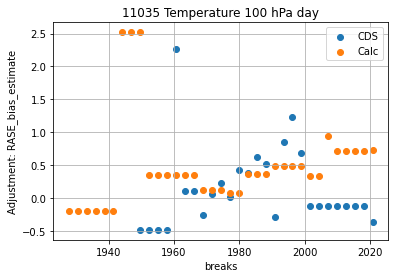

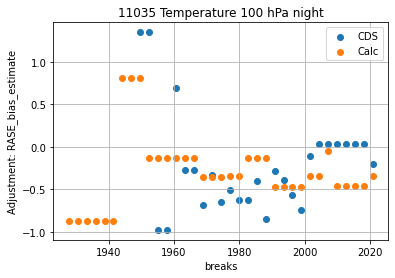

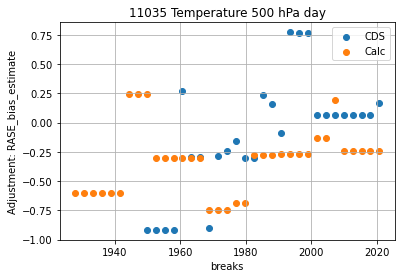

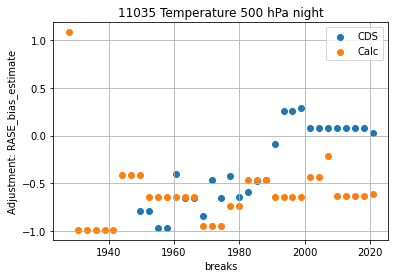

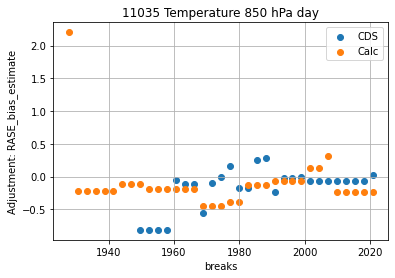

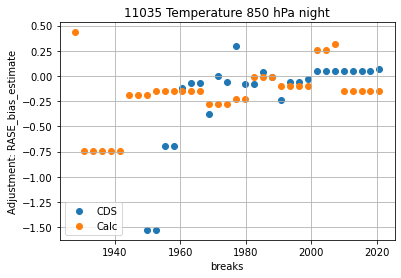

In [21]:
station = '11035'
adj = 'RASE_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:31:12,129 INFO Welcome to the CDS
2021-06-10 15:31:12,130 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-10 15:31:12,314 INFO Request is completed
2021-06-10 15:31:12,316 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331812.4981277-29961-16-7a05dfd2-cc5e-4725-a362-a607cd389c1a.zip to download.zip (29M)
2021-06-10 15:31:16,474 INFO Download rate 7M/s     
2021-06-10 15:31:16,898 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1951, 9, 28, 0, 0), datetime.datetime(1956, 6, 23, 0, 0), datetime.datetime(1958, 6, 24, 0, 0), datetime.datetime(1963, 7, 12, 0, 0), datetime.datetime(1965, 8, 15, 0, 0), datetime.datetime(1968, 1, 2, 0, 0), datetime.datetime(1969, 10, 4, 0, 0), datetime.datetime(1973, 2, 15, 0, 0), datetime.datetime(1974, 11, 22, 0, 0), datetime.datetime(1976, 2, 4, 0, 0), datetime.datetime(1980, 3, 31, 0, 0), datetime.datetime(1982, 1, 19, 0, 0), datetime.datetime(1984, 1, 20, 0, 0), datetime.datetime(1987, 4, 16, 0, 0), datetime.datetime(1989, 8, 24, 0, 0), datetime.datetime(1994, 6, 5, 0, 0), datetime.datetime(1996, 8, 13, 0, 0), datetime.datetime(2016, 12, 15, 0, 0), datetime.datetime(2019, 5, 15, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


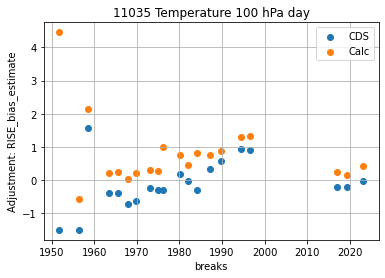

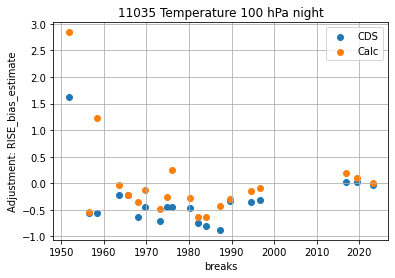

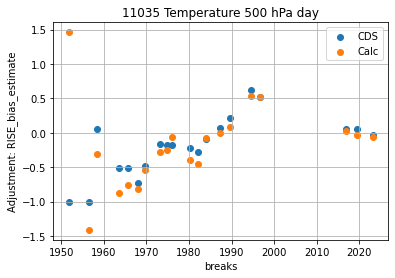

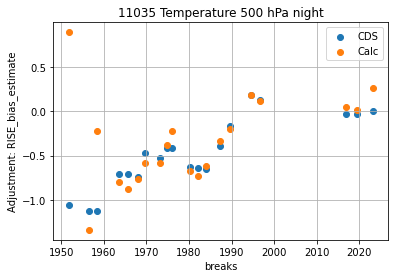

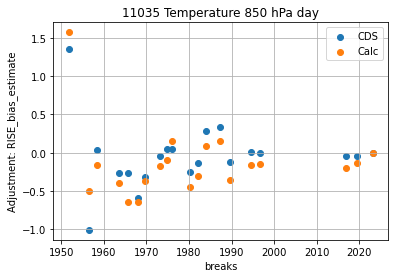

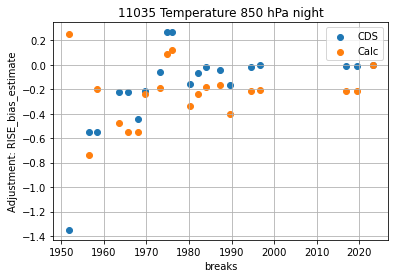

In [22]:
station = '11035'
adj = 'RISE_bias_estimate'
dates, cd, cn, ad, an = get_adj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)

2021-06-10 15:31:37,381 INFO Welcome to the CDS
2021-06-10 15:31:37,383 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-06-10 15:31:37,541 INFO Request is completed
2021-06-10 15:31:37,542 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1623331812.4981277-29961-16-7a05dfd2-cc5e-4725-a362-a607cd389c1a.zip to download.zip (29M)
2021-06-10 15:31:42,793 INFO Download rate 5.5M/s   
2021-06-10 15:31:43,244 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00


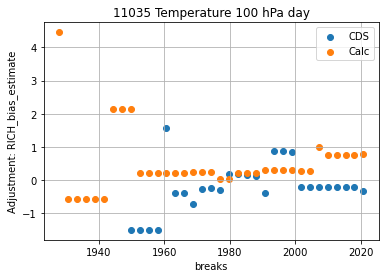

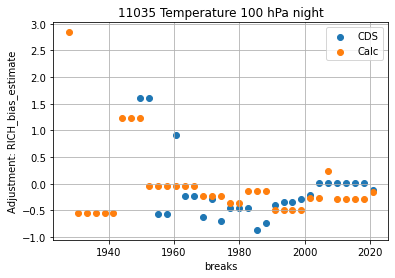

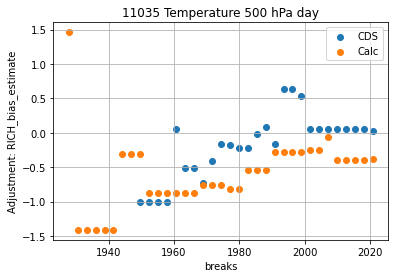

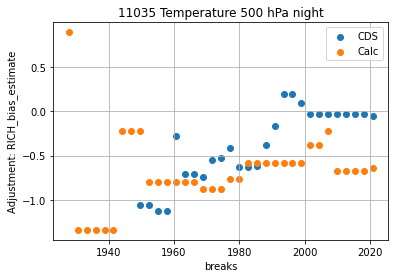

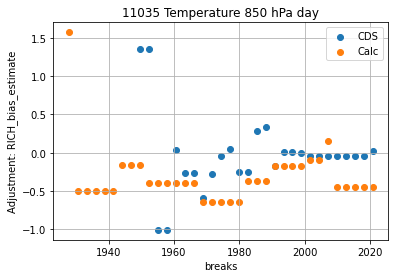

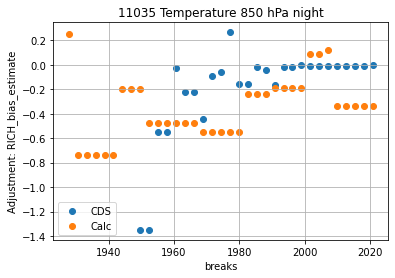

In [23]:
station = '11035'
adj = 'RICH_bias_estimate'
dates, cd, cn, ad, an = get_sacadj(station, adj)
plt_adj(dates, cd, ad, 100, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 100, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 500, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 500, station, 'night', adj, save=False)
plt_adj(dates, cd, ad, 850, station, 'day', adj, save=False)
plt_adj(dates, cn, an, 850, station, 'night', adj, save=False)